In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))   # Mean & std for MNIST
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [4]:
# === 1. Define Basic Residual Block ===
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out.clone() + identity
        out = F.relu(out)
        return out


# === 2. Build ResNet for MNIST (1 input channel) ===
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


# === 3. Create Model, Optimizer, Loss ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === 4. Training Function ===
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}")

# === 5. Evaluation Function ===
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


# === 6. Run Training + Evaluation ===
train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)
evaluate(model, test_loader, device)


Epoch 1/5: 100%|██████████| 938/938 [00:18<00:00, 50.35it/s]


Epoch [1/5] Loss: 0.1590


Epoch 2/5: 100%|██████████| 938/938 [00:20<00:00, 45.97it/s]


Epoch [2/5] Loss: 0.0449


Epoch 3/5: 100%|██████████| 938/938 [00:20<00:00, 46.29it/s]


Epoch [3/5] Loss: 0.0328


Epoch 4/5: 100%|██████████| 938/938 [00:17<00:00, 52.16it/s]


Epoch [4/5] Loss: 0.0286


Epoch 5/5: 100%|██████████| 938/938 [00:20<00:00, 46.80it/s]


Epoch [5/5] Loss: 0.0230
Test Accuracy: 98.77%


98.77

In [5]:
import cv2

In [18]:
target_layers = [
    model.layer1[-1].conv2,
    model.layer2[-1].conv2,
    model.layer3[-1].conv2
]

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backprop for that specific class
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, target_class


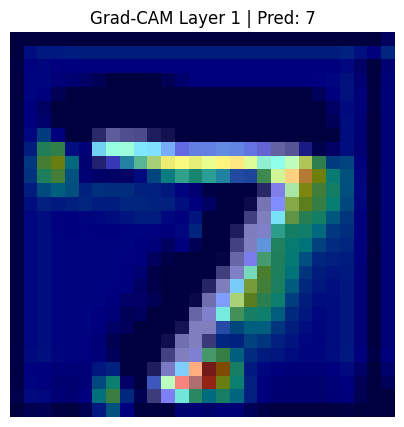

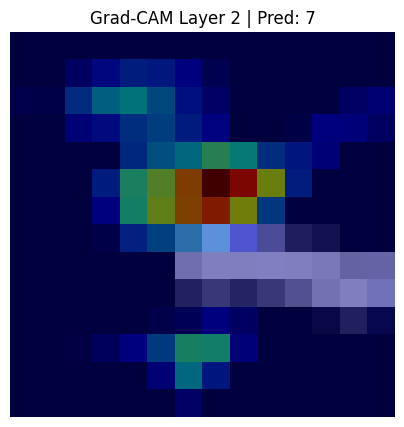

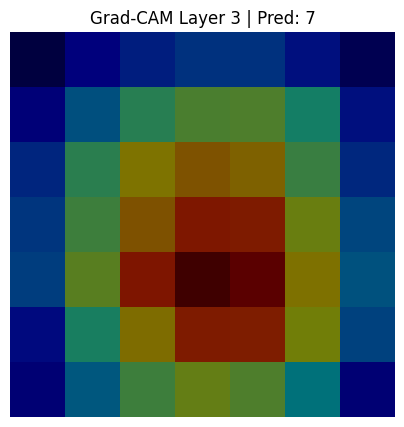

In [ ]:
# Pick one test image
data_iter = iter(test_loader)
images, labels = next(data_iter)
image = images[0:1].to(device)
label = labels[0].item()

# Target layer = last convolutional block
target_layer = model.layer3[-1].conv2  # You can change this (try last block’s bn2 or conv2)
grad_cam = GradCAM(model, target_layer)

# Generate CAM
# cam, predicted_class = grad_cam.generate_cam(image)

# # Convert grayscale image to numpy for plotting
# img = image.cpu().squeeze().numpy()
# img = (img - img.min()) / (img.max() - img.min() + 1e-5)

# # Resize cam to match input size
# cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

# # Overlay CAM heatmap
# heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
# heatmap = np.float32(heatmap) / 255
# overlay = 0.5 * heatmap[..., 2] + 0.5 * img  # for grayscale

# # === Plot results ===
# plt.figure(figsize=(10, 4))

# plt.subplot(1, 3, 1)
# plt.title(f"Original (Label {label})")
# plt.imshow(img, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title("Grad-CAM Heatmap")
# plt.imshow(cam_resized, cmap='jet')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title(f"Overlay (Pred {predicted_class})")
# plt.imshow(overlay, cmap='jet')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

for i, layer in enumerate(target_layers):
    grad_cam = GradCAM(model, layer)
    cam, predicted_class = grad_cam.generate_cam(image)

    plt.figure(figsize=(5, 5))
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM Layer {i+1} | Pred: {predicted_class}")
    plt.axis('off')
    plt.show()